In [1]:
# define packages
using Plots, NLSolvers, DifferentialEquations, Plots.PlotMeasures, LaTeXStrings, Roots, NLsolve

In [2]:
# define constants
const V0 = 3. # the value has to be taken from the figure 1
const N = 400 # number of x points
const L_real_turing = 0.05 # total length also non-dimensional point (l/re)
const L_real_waves = 0.015
const c = 1.82;
const Vr = 3;
const dt = 0.05;   # adimensional time step 

In [ ]:
######## FIGURE 1 #########

V=0:0.01:6   #range of membrane potentials
S=1 ./(1 .+exp.(-c.*(V.-Vr)))  #sigmoid function

a_e=6 
a_i=5
brok_li_1=1.8
brok_li_2=2.5
brok_li_3=3.2
y_1= V.*(1.5)./1.5.+brok_li_1  #equation of the first broken line
y_2= V.*(1.5)./1.5.+brok_li_2  #equation of the second broken line
y_3= V.*(1.5)./1.5.+brok_li_3  #equation of the third broken line

# Plot Figure 1
p=plot( y_1, V, linestyle=:dash, color=:black, xlims=(0, 6), ylims=(0, 1.5), grid=false, legend=false,title="Figure 1") 

plot!(y_2, V, linestyle=:dash, color=:black)
plot!(y_3, V, linestyle=:dash, color=:black)
plot!(V, S, color=:black)

plot!(
    xticks=(
        vcat(0:1:6, 0:0.2:6),                
        vcat(["", "1.00", "2.00", "3.00", "4.00", "5.00", " "], repeat("", 30)) 
    ),
    yticks=(
        vcat(0:0.25:2, 0:0.05:2), 
        vcat(["", "0.25", "1.0", "1.5", "1.25", "1.75", " "], repeat("", 30))  
    ),
    
)

annotate!(5.8, -0.07, text("V", :left, 12))
annotate!(2, 0.8, text("µPo = 1.8", :black, 12))  
annotate!(3.6, 1.2, text("µPo = 2.5", :black, 12))
annotate!(4.2, 0.42, text("µPo = 3.2", :black, 12))
annotate!(5.45, 1.07, text("S(V)", :black, 12))

display(p)

# Define the non linear equation as a function
function equation(V)
    V[1] - (a_e - a_i) * (1 / (1 + exp(-c * (V[1] - Vr)))) -µ_Po
end


# Solve 
µ_Po=1.8
result = nlsolve(equation, [0.5])  
println("Solution for V0[1]: ", result.zero[1])

µ_Po=2.5
result = nlsolve(equation, [0.5])
println("Solution for V0[1]: ", result.zero[1])

µ_Po=3.2
result = nlsolve(equation, [0.5])
println("Solution for V0[1]: ", result.zero[1])

   

In [ ]:
######## FIGURE 2 #########

γ_c(k, r, ae, ai) = (r^2 + (1 + r^2) * k^2 + k^4) / ((ae - ai) * r^2 + (ae - ai * r^2) * k^2)

r_range = [1/4,1/2, 3/4, 1]
k = 0:0.01:2.0
ae = 6
ai = 5

plot(k, [γ_c.(k, r, ae, ai) for r in r_range], ylim = (0,1.5), label = ["r = 1" "r = 1/4" "r = 3/4" "r = 1/2"], xlabel = 'k', ylabel = 'γ', lw = 2,
legend = :topleft, title="Figure 2")

In [ ]:
######## FIGURE 3 #########

# Define a function for the synaptic kernel K(|x - x'|)
# r = re/ri
function synaptic_kernel(x, ae, ai, r)
    ex = exp.(-x)            
    return ae .* ex - ai .* r .* (ex .^ r)  
end

# r < 1
x1 = 0.:0.1:20.               # Define x range
ae1, ai1, r1 = 6., 5., 0.25   # Parameters
K1 = synaptic_kernel(x1, ae1, ai1, r1)
plot1 = plot(
    x1, K1,
    xlabel="|x - x'|", ylabel="synaptic kernel K(|x - x'|)",
    title="r < 1", color=:black, lw=2, grid=false, legend=false,
    xlims=(0.1, 22), ylims=(-0.7, 5.1), framestyle=:origin
)

# r > 1
x2 = 0.:0.05:4.1              # Define x range
ae2, ai2, r2 = 41., 40., 10.  # Parameters
K2 = synaptic_kernel(x2, ae2, ai2, r2)
plot2 = plot(
    x2, K2, legend=false, xlabel="Figure 3",
    title="r > 1", color=:black, lw=2, grid=false,
    xlims=(0, 4.2), ylims=(-450, 50), framestyle=:origin
)

plot(plot1, plot2, layout=(1, 2))

In [14]:
######## Main Code - Figure 7, 8, 9, 10, 11 ########

# define functions

function sigmoid(V_mat)  # compute the sigmoid function for each value of the input matrix. The output has the same size of the input.
    return 1 ./ (1 .+ exp.(-c .* (V_mat.-Vr)))
end

const G0 = 2 .* sigmoid(V0*ones(1,N+1)) # precompute the value of G when the time is negative

function G(V,nt,n,du,v) # compute the G. V is the whole matrix, nt is the current iteration and n is the index of the spatial-temporal delay
    nx = 0:N  # vector of the index in the x axis
    timedelayed = nt*dt .- (n.*du./v)   # delay in adimensional seconds
    ntdelayed = Int64(round(timedelayed / dt))   # delay in terms of indexes
    if ntdelayed < 1
        return G0    # if the time is negative return the precomputed value
    else
        G1 = sigmoid(V[ntdelayed,mod1.((nx.-n.+1),N+1)])  # compute the G for the two different (opposite) delays
        G2 = sigmoid(V[ntdelayed,((nx.+n).%(N+1).+1)])    # circular shift with the indexes
        return permutedims(G1.+G2)
    end      
end

function integral_function(V,nt,eta,du,v,c1,c2)
    b = (1/eta).*(G(V,nt,0,du,v).+(G(V,nt,1,du,v).-G(V,nt,0,du,v))./(eta.*du));
    K = c2.*(G(V,nt,N+1,du,v).+(G(V,nt,N+1,du,v).-G(V,nt,N,du,v))./(eta.*du))
    cc = zeros(N-1,N+1)
    for nn = 0:N-2
        cc[nn+1,:] = exp.(-eta.*((nn+1).*du)).*(G(V,nt,nn+2,du,v).-2 .*G(V,nt,nn+1,du,v).+G(V,nt,nn,du,v)); # compute the sum
    end 
    summ = sum(cc,dims=1)
    return c1.*summ .+ b .- K
end

function J_function(V,nt,eta,du,v,ae,ai,c1,c2)
    return 0.5 .*(ae.*eta[1].*integral_function(V,nt,eta[1],du,v,c1[1],c2[1]) .- ai.*eta[2].*integral_function(V,nt,eta[2],du,v,c1[2],c2[2]))
end

function brainPatterns(V,eta,du,v,ae,ai,muP,L,N_t)
    ########################################
    # main function of the code:
    # V : matrix that has to be initialized outside the function, with N+1 columns and N_t rows. The first row has to be V0 + gaussian noise
    # eta : vector where the first element must be the excitatory eta and the second the inhibitory eta
    # du : spatial step (value)
    # v : propagation velocity (value)
    # ae : excitatory interaction strenght (value)
    # ai : inhibitory interaction strenght (value)
    # muP : external interaction. Has to be a matrix with the same size of V
    # L : total length (value, adimensional)
    # N_t : length of the time vector
    ########################################
    
    # define matrixes used 
    J=zeros(size(V)); phi = zeros(size(V));
    # compute constant parameters that do not depend on the nt
    c1 = 1 ./ ((eta.^2).*du);
    c2 = (1 ./eta).*exp.(-eta.*L)
    
    println("number of total iterations: ", (N_t-1))
    for nt = 1:N_t-1
        # iteration check
        if nt%500 == 0
            println("iteration #", nt)
        end
        J[nt,:] = J_function(V,nt,eta,du,v,ae,ai,c1,c2);
        V[nt+1,:] = V[nt,:] .+ dt.*phi[nt,:]
        phi[nt+1,:] = phi[nt,:] .+ dt.*(-2 .*phi[nt,:] .- V[nt,:] .+ J[nt,:] .+ muP[nt,:])
    end
    return V,J,phi
end

brainPatterns (generic function with 1 method)

In [4]:
# matrix V initialization
# precompute perturbation so it is the same for every figure

V_perturb = V0.*ones(1,N+1) .+ 0.0005 .*randn(1,N+1);

# external stimulus
muP0_val = 2.5;

In [21]:
######## Turing Patterns (FIG. 7) ########
# parameters
ae = 6.;     # excitatory strenght
ai = 5.;     # inhibitory strenght
re = 0.0005;    # excitatory range (m)
ri = 0.001;     # inhibitory range (m)
r = re/ri;   # ratio

v_real = 0.08; # propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))

L = L_real_turing / re
du = L/N; x = 0:du:L;

eta_e = 1.0
eta_i = r
eta = [eta_e eta_i]

# define time axis
T = 1200
t = 0:dt:T
N_t = length(t);

In [22]:
# main cycle fig. 7
# initialize V
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
V[1,:] = V_perturb

# initialize the external stimulation
muP0 = muP0_val*ones(size(V))

# compute the pattern
@time begin
V7,J7 = brainPatterns(V,eta,du,v,ae,ai,muP0,L,N_t);
end

number of total iterations: 24000
iteration #500
iteration #1000
iteration #1500
iteration #2000
iteration #2500
iteration #3000
iteration #3500
iteration #4000
iteration #4500
iteration #5000
iteration #5500
iteration #6000
iteration #6500
iteration #7000
iteration #7500
iteration #8000
iteration #8500
iteration #9000
iteration #9500
iteration #10000
iteration #10500
iteration #11000
iteration #11500
iteration #12000
iteration #12500
iteration #13000
iteration #13500
iteration #14000
iteration #14500
iteration #15000
iteration #15500
iteration #16000
iteration #16500
iteration #17000
iteration #17500
iteration #18000
iteration #18500
iteration #19000
iteration #19500
iteration #20000
iteration #20500
iteration #21000
iteration #21500
iteration #22000
iteration #22500
iteration #23000
iteration #23500
iteration #24000
1005.213632 seconds (485.25 M allocations: 1.238 TiB, 9.37% gc time)


([2.999942276895374 2.9997677871654265 … 3.0011804337594112 2.9999998864501447; 2.999942276895374 2.9997677871654265 … 3.0011804337594112 2.9999998864501447; … ; 3.5581998146708718 3.583138468078344 … 3.469896259095006 3.5204006962550842; 3.558201043687363 3.58313919430826 … 3.4698984682881604 3.5204024221655565], [0.4999897217706577 0.4999586519687029 … 0.5002101890451938 0.4999999797812076; 0.4999897217706577 0.4999586519687029 … 0.5002101890451938 0.4999999797812076; … ; 1.058249084245959 1.0831675768577833 … 0.9699848443275911 1.0204698940886177; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 2.372243764181548e-6 9.543240163822909e-6 … -4.85122357108736e-5 4.6665531439060715e-9; … ; 2.4580329821436318e-5 1.452459831380587e-5 … 4.4183863087288474e-5 3.451820944263743e-5; 2.4585775593669478e-5 1.4527577454384545e-5 … 4.419473840779928e-5 3.452628017505314e-5])

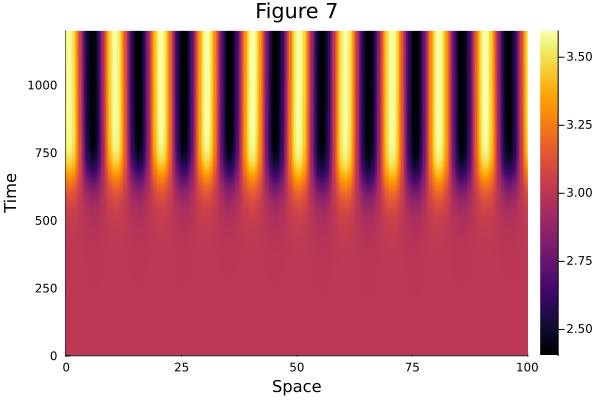

In [23]:
# display the pattern
heatmap(x, t, V7; xlabel="Space", ylabel="Time", title="Figure 7")

In [11]:
######## Waves - homogeneous stimulus - close to the threshold (FIG. 8) ########

ae = 41;     # excitatory strenght
ai = 40;     # inhibitory strenght
re = 0.001;    # excitatory range (m)
ri = 0.00037;     # inhibitory range (m)
r = re/ri;   # ratio

v_real = 0.16;# propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))

L = L_real_turing / re #############################
du = L/N; x = 0:du:L;

eta_e = 1.0
eta_i = r
eta = [eta_e eta_i]

# define time axis
T = 400 #adimensional time
t = 0:dt:T
N_t = length(t);

In [12]:
# main cycle - fig 8

# initialize V
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
V[1,:] = V_perturb

# initialize the external stimulation
muP0 = muP0_val*ones(size(V))

# compute the pattern
@time begin
V8,J8 = brainPatterns(V,eta,du,v,ae,ai,muP0,L,N_t);
end

1×2 Matrix{Float64}:
 8.0  1.0952

1×2 Matrix{Float64}:
 1.92875e-22  7.58155e-60

number of total iterations: 8001
iteration number: 500
iteration number: 1000
iteration number: 1500
iteration number: 2000
iteration number: 2500
iteration number: 3000
iteration number: 3500
iteration number: 4000
iteration number: 4500
iteration number: 5000
iteration number: 5500
iteration number: 6000
iteration number: 6500
iteration number: 7000
iteration number: 7500
iteration number: 8000
332.287550 seconds (152.73 M allocations: 400.324 GiB, 7.64% gc time)


([2.999942276895374 2.9997677871654265 … 3.0011804337594112 2.9999998864501447; 2.999942276895374 2.9997677871654265 … 3.0011804337594112 2.9999998864501447; … ; 3.326416107087641 3.314902094859785 … 3.3529989243673293 3.3398378297987064; 3.2905205148128807 3.2777150111834077 … 3.3202722125575805 3.305418522071619], [0.5000944725068202 0.5003800510806293 … 0.49806804408198957 0.5000001858413476; 0.5000944725068202 0.5003800510806293 … 0.49806804408198957 0.5000001858413476; … ; -1.8198931956136093 -1.8415142337772465 … -1.7607890791177603 -1.7944060013695946; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 7.609780572304104e-6 3.0613195760142986e-5 … -0.00015561948387108338 1.496956014701567e-8; … ; -0.7179118454952028 -0.7437416735275428 … -0.6545342361949724 -0.6883861545417552; -0.7784361260807451 -0.8021883226066401 … -0.7197702127497296 -0.7512597306459947])

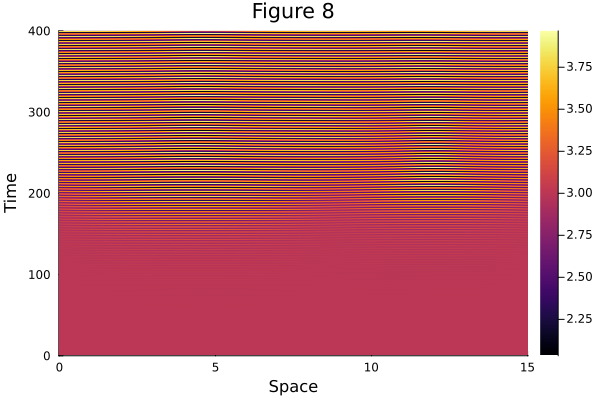

In [10]:
heatmap(x,t,V8; xlabel="Space", ylabel="Time", title="Figure 8") # L = L_real_waves


In [15]:
######## FIGURE 9 ########
# Waves - Homogeneous external stimulation - Well above threshold

re = 0.001;       # excitatory range (m)
ri = 0.0001;
ai = 100.;
ae = 101.;
r = re/ri;   # ratio

v_real = 0.16; # propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))

L = L_real_waves / re
du = L/N; x = 0:du:L;

eta_e = 1.0
eta_i = r
eta = [eta_e eta_i]

# define time axis
T = 200
t = 0:dt:T
N_t = length(t);

In [16]:
# main cycle - fig 9

# initialize V
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
V[1,:] = V_perturb

# initialize the external stimulation
muP0 = muP0_val*ones(size(V))

# compute the pattern
@time begin
V9,J9 = brainPatterns(V,eta,du,v,ae,ai,muP0,L,N_t);
end

number of total iterations: 4000
iteration #500
iteration #1000
iteration #1500
iteration #2000
iteration #2500
iteration #3000
iteration #3500
iteration #4000
166.232675 seconds (82.71 M allocations: 213.581 GiB, 9.04% gc time, 1.75% compilation time)


([2.999942276895374 2.9997677871654265 … 3.0011804337594112 2.9999998864501447; 2.999942276895374 2.9997677871654265 … 3.0011804337594112 2.9999998864501447; … ; -1.2249465442416185 -1.2614249258215324 … -1.1522076671207933 -1.1885112737322385; -0.8607580531243516 -0.90599283845804 … -0.7708937804624041 -0.8156860818813966], [0.500371688099392 0.5015419523175311 … 0.4920676453816384 0.49998531348671804; 0.500371688099392 0.5015419523175311 … 0.4920676453816384 0.49998531348671804; … ; 39.49114960726362 39.44007991808207 … 39.58403586357201 39.539138381092805; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 2.1470560200897995e-5 8.870825760523005e-5 … -0.0004556394188886426 -7.286481713331128e-7; … ; 7.283769822345338 7.108641747269846 … 7.626277733167784 7.456503837016839; 8.716197647686066 8.557852814738041 … 9.025462136385647 8.872235936056407])

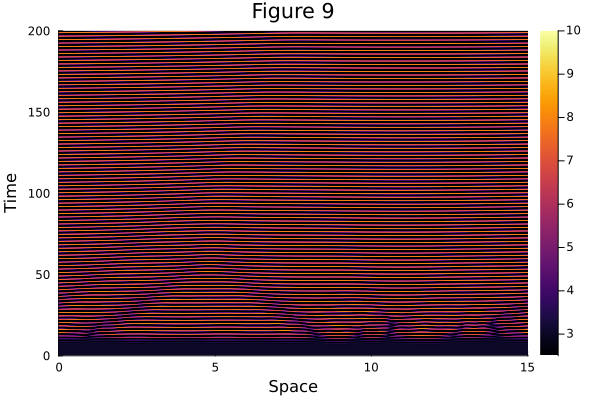

In [17]:
heatmap(x,t,V9; clim=(2.5,10),xlabel="Space", ylabel="Time", title="Figure 9")

In [ ]:
######## FIGURE 10 ########
# Waves - inhomogeneous stimulus - close to the threshold

ae = 41;     # excitatory strenght
ai = 40;     # inhibitory strenght
re = 0.001;    # excitatory range (m)
ri = 0.00037;     # inhibitory range (m)
r = re/ri;   # ratio

v_real = 0.16;# propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))

L = L_real_waves / re;
du = L/N; x = 0:du:L;

eta_e = 1.0
eta_i = r
eta = [eta_e eta_i]

# define time axis
T = 200
t = 0:dt:T
N_t = length(t);

In [ ]:
# main cycle - fig 10

# initialize V
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
V[1,:] = V_perturb

# initialize and define inhomogeneous external stimuli 
muP = muP0_val*ones(size(V))
x1 = Int64(round((0.475*L)/(du)))+1;
x2 = Int64(round((0.525*L)/(du)))+1;
t1 = Int64(49/dt)+1;
t2 = Int64(130/dt)+1;
for i = x1:x2
    #muP[:,i] = muP[:,i] .+ 20;
    muP[t1:t2,i] = muP[t1:t2,i] .+ 20;
end

# compute the pattern
@time begin
V10,J10 = brainPatterns(V,eta,du,v,ae,ai,muP,L,N_t);
end

In [ ]:
heatmap(x,t,V10; clim=(2.5,3.5),xlabel="Space", ylabel="Time", title="Figure 10")

In [ ]:
######## FIGURE 11 ########
# Waves - Homogeneous external stimulation - Well above threshold
re = 0.001;       # excitatory range (m)
ri = 0.0001;
ai = 100.;
ae = 101.;
r = re/ri;   # ratio

v_real = 0.16; # propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))

L = L_real_waves / re
du = L/N; x = 0:du:L;

eta_e = 1.0
eta_i = r
eta = [eta_e eta_i]

# define time axis
T = 200
t = 0:dt:T
N_t = length(t);

In [ ]:
# main cycle - fig 11

# initialize V
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
V[1,:] = V_perturb

# initialize and define inhomogeneous external stimuli 
muP = muP0_val*ones(size(V))
x1 = Int64(round((0.475*L)/(du)))+1;
x2 = Int64(round((0.525*L)/(du)))+1;
t1 = Int64(49/dt)+1;
t2 = Int64(130/dt)+1;

for i = x1:x2 # space indexes
    muP[t1:t2,i] = muP[t1:t2,i] .+ 20; # time indexes
end

@time begin
    V11,J11 = brainPatterns(V,eta,du,v,ae,ai,muP,L,N_t);
end

In [ ]:
heatmap(x,t[1:1000],V11[1:1000,:]; clim=(2.5,10), xlabel="Space", ylabel="Time",title="Figure 11")